# Utils

In [56]:
import os

def save_reviews(df_review, file, path='data'):
    f = f'{path}/{file}'
    if os.path.exists(f):
        print(f'ERROR: {f} already exists')
    else:
        df_review.to_csv(f, index=False)
        print(f'{f} saved.')
    return None

def load_reviews(file, path='data'):
    f = f'{path}/{file}'
    df = pd.read_csv(f, parse_dates=['date'])
    print(f'{f} loaded.')
    return df

# Scraping

In [4]:
from vivino_community_reviews import vivino_reviews, concat_reviews

import pandas as pd

In [2]:
locator_more = "//button[@tabindex='0']"
locator_recent = '//*[@data-testid="baseModalBackdrop"]/div[2]/div[2]/div[2]/div/a[1]'

locator_review = "communityReview__reviewText--2bfLj"
locator_date = "anchor_anchor__m8Qi- reviewAnchor__anchor--2NKFw reviewDate__reviewDate--49vpM undefined"

kwargs = {
    'loc1': locator_more,
    'loc2': locator_recent, 
    'loc3': locator_review,
    'loc4': locator_date
}

In [3]:
kwargs.update({
    'end_date': '20220101',
    #'max_scr': 10, 'time_scr': 2, 'check_idx': 4,
})

In [4]:
wines = list()
wines.append([
    'Casillero del Diablo Cabernet Sauvignon (Reserva)',
    'https://www.vivino.com/casillero-del-diablo-cabernet-sauvignon-reserva-central-valley/w/1135067?ref=nav-search#all_reviews'
])
wines.append([
    'Yellow Tail Cabernet Sauvignon',
    'https://www.vivino.com/yellow-tail-cabernet-sauvignon/w/2549?ref=nav-search#all_reviews'
])

id_start = 0

In [4]:
wines = list()
wines.append([
    'Casillero del Diablo Chardonnay (Reserva)',
    'https://www.vivino.com/casillero-del-diablo-chardonnay-reserva/w/1135140?ref=nav-search#all_reviews'
])

id_start = 6

**load existing reviews**

In [8]:
#files = []
files = ['wine_6']
path = 'data'

df_reviews = pd.DataFrame()
for f in files:
    df = load_reviews(f'{f}.csv', path=path)
    df_reviews = pd.concat([df_reviews, df])

# check duplicate wid
df_reviews.groupby('wid').wine.unique()

data/wine_6.csv loaded.


wid
6    [Casillero del Diablo Chardonnay (Reserva)]
Name: wine, dtype: object

In [5]:
col_rev = ['id', 'wine', 'date', 'review']

for wine_name, wine_url in wines:
    df = vivino_reviews(wine_url, wine_name, **kwargs)
    df_reviews = concat_reviews(df_reviews, df, wine_name, col_rev, save=True, id_start=id_start)

123it [01:54,  1.08it/s]

123 reviews collected.


**temp saving before translation**

In [14]:
save_reviews(df_reviews, 'wine_reviews.csv', 'data')

data/wine_reviews.csv saved.


# Review data

In [40]:
df_reviews = load_reviews('wine_reviews.csv', 'data')

data/wine_reviews.csv loaded.


In [41]:
cond = (df_reviews.date.isna()) | (df_reviews.review.isna())
df_reviews.loc[cond]

,wid,wine,date,review,source
120,6,Casillero del Diablo Chardonnay (Reserva),NaT,NaN,vivino


In [42]:
df_reviews = df_reviews.loc[~cond].reset_index(drop=True)

In [43]:
df_reviews.date.dt.year.value_counts().sort_index(ascending=False)

date
2024     5
2023    47
2022    67
2021     3
Name: count, dtype: int64

<Axes: >

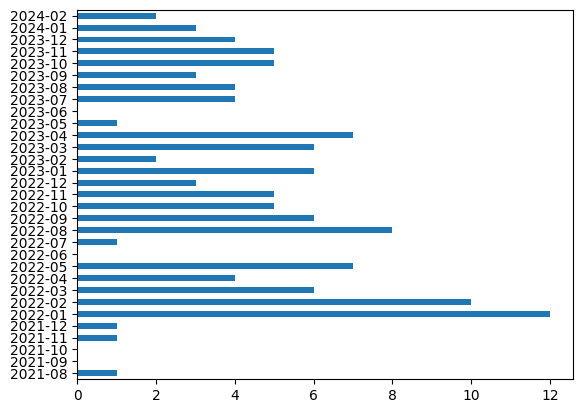

In [19]:
d = df_reviews.date.agg(['min', 'max']).to_list()
date_range = pd.date_range(start=d[0], end=d[1]).to_period("M").unique()

(df_reviews
 .set_index('date').to_period("M")
 .groupby(level=0).review.count()
 .sort_index()
 .reindex(date_range, fill_value=0)
 .plot(kind='barh')
)

<Axes: ylabel='wine'>

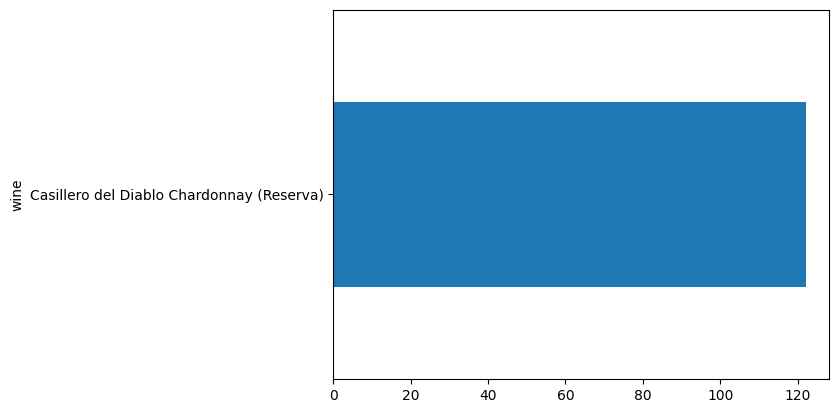

In [20]:
(df_reviews
 .groupby(by='wine').review.count()
 .plot(kind='barh')
)

In [21]:
df_reviews.head()

,wid,wine,date,review,source
0,6,Casillero del Diablo Chardonnay (Reserva),2024-02-03,"cu 1.6 구매, 소비뇽블랑같은 맛",vivino
1,6,Casillero del Diablo Chardonnay (Reserva),2024-02-02,Chardonnay da onipresente Concha y Toro. É agr...,vivino
2,6,Casillero del Diablo Chardonnay (Reserva),2024-01-29,Aroma de pêssego bem presente!! Harmoniza bem ...,vivino
3,6,Casillero del Diablo Chardonnay (Reserva),2024-01-26,"It's a pretty rough Chardonnay, unbalanced and...",vivino
4,6,Casillero del Diablo Chardonnay (Reserva),2024-01-01,Bom custo beneficio,vivino


# Translate

In [22]:
import langdetect
import json
from deep_translator import GoogleTranslator
from tqdm import tqdm

def detect_language(text):
    try:
        return langdetect.detect(text)
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

def get_translation(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(str(text))
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

In [45]:
tmp_data = []

for rec in tqdm(df_reviews.to_dict('records')):
    tmp_data.append({
        #'wid': rec['wid'],
        'lang': detect_language(rec['review']),
        'review_transl': get_translation(rec['review'])
    })

100%|█████████████████████████████████████████████████████████████| 122/122 [01:54<00:00,  1.07it/s]


In [48]:
df_reviews = df_reviews.merge(pd.DataFrame(tmp_data), left_index=True, right_index=True)
df_reviews.head()

,wid,wine,date,review,source,lang,review_transl
0,6,Casillero del Diablo Chardonnay (Reserva),2024-02-03,"cu 1.6 구매, 소비뇽블랑같은 맛",vivino,ko,"Purchased cu 1.6, tastes like sauvignon blanc"
1,6,Casillero del Diablo Chardonnay (Reserva),2024-02-02,Chardonnay da onipresente Concha y Toro. É agr...,vivino,pt,Chardonnay from the ubiquitous Concha y Toro. ...
2,6,Casillero del Diablo Chardonnay (Reserva),2024-01-29,Aroma de pêssego bem presente!! Harmoniza bem ...,vivino,pt,Peach aroma very present!! Pairs well with sea...
3,6,Casillero del Diablo Chardonnay (Reserva),2024-01-26,"It's a pretty rough Chardonnay, unbalanced and...",vivino,en,"It's a pretty rough Chardonnay, unbalanced and..."
4,6,Casillero del Diablo Chardonnay (Reserva),2024-01-01,Bom custo beneficio,vivino,en,Good cost-benefit


**save final data**

In [58]:
from datetime import datetime
d = datetime.today().strftime('%y%m%d')
save_reviews(df_reviews, f'wine_reviews_{d}.csv')

ERROR: data/wine_reviews_240207.csv already exists
